# Photon Counting

Heavily based on http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/

Static photon source e.g. MS star

Generate data set (dummy measurements)

In [1]:
# Generate data, photon measurements
import numpy as np
from scipy import stats
np.random.seed(88)

F_true = 1000 # true flux, e.g. number of photons measured in 1 second
N = 50 # number of observations/measurements
F = stats.poisson(F_true).rvs(N) # N measurements of the flux
e = np.sqrt(F) # error on Poisson counts estimated via square root

Plot the data

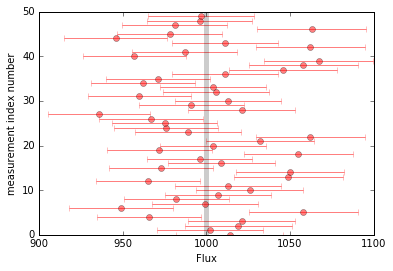

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ro', ecolor='red', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("Flux")
ax.set_ylabel("measurement index number")

Given our measurements and errors, what is our best estimate of the true flux?

## Frequentist Approach to Simple Photon Counts

Classical frequentist approach: <b>Maximum likelihood</b> 

Given a single observation $D_i = (F_i, e_i)$, and Gaussian error assumption

$$P(D_i | F_\text{true}) = \frac{1}{\sqrt{2 \pi e_i^2}} \exp{\left[ \frac{-(F_i - F_\text{true})^2}{2e_i^2} \right]}$$

We construct the likelihood function by computing the product of the probabilities for each data point (uncorrelated)

$$\mathcal{L} (D | F_\text{true}) = \prod_{i=1}^{N} P(D_i|F_\text{true})$$

because $\mathcal{L}$ will become very small, it is more convenient to use $\log\mathcal{L}$

$$\log\mathcal{L} = -\frac{1}{2} \sum_{i=1}^{N} \left[ \log{2 \pi e_i^2} + \frac{(F_i - F_\text{true})^2}{e_i^2} \right]$$

What we'd like to do is determine $F_\text{true}$ such that the likelihood is maximized. 

Analytically, by setting $\frac{d \log \mathcal{L}}{d F_\text{true}}=0$, we will get

$$F_\text{est} = \frac{ \sum_{i=1}^{N} w_i F_i}{ \sum_{i=1}^{N} w_i}, \quad w_i = \frac{1}{e_i^2}$$

We can go further and ask what the error of our estimate is. In the frequentist approach, this can be accomplished by fitting a Gaussian approximation to the likelihood curve at maximum; in this simple case this can also be solved analytically. It can be shown that the standard deviation of this Gaussian approximation is

$$\sigma_\text{est} = \left( \sum_{i=1}^{N} w_i \right)^{-1/2}$$

In [3]:
w = 1/(e*e)
F_est = (w * F).sum() / w.sum()
sigma_est = 1/np.sqrt(w.sum())

In [4]:
print "F_true = {0}\nF_est = {1:.0f} +- {2:.0f}\nBased on {3} measurements".format(F_true, F_est, sigma_est, N)

F_true = 1000
F_est = 1002 +- 4
Based on 50 measurements


## Bayesian Approach to Simple Photon Counts

In [5]:
import emcee

In [6]:
def log_prior(theta):
    return 0 # flat prior

def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * e**2 ) + (F - theta[0]) **2 / e ** 2)

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

In [7]:
ndim = 1 # number of parameters in model
nwalkers = 50 # number of MCMC walkers
nburn = 1000 # burn-in, discard unstable period (correlated)
nsteps = 2000 # number of MCMC steps

# random location between 0 to 2000
init_guess = 2000 * np.random.rand(nwalkers, ndim)

In [8]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(init_guess, nsteps);

In [9]:
sample = sampler.chain 

In [10]:
np.shape(sample) # shape = (nwalkers, nsteps, ndim)

(50, 2000, 1)

In [11]:
# discard burn in
accept_sample = sample[:, nburn:, :].ravel()

F_est_bayes = np.mean(accept_sample)
sigma_est_bayes = np.std(accept_sample)

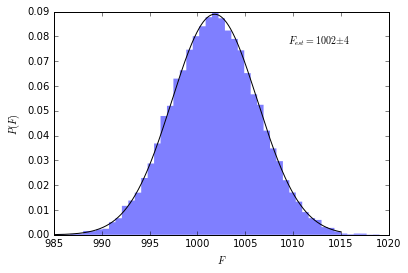

In [12]:
# plot posterior
plt.hist(accept_sample, normed=True, bins=50, histtype="stepfilled", alpha=0.5, linewidth=0)

# fit gaussian
x = np.linspace(985, 1015, 1000)
y = stats.norm(F_est_bayes, sigma_est_bayes).pdf(x)
plt.plot(x, y, 'k-')

text = r'$F_{est} = ' + '{0:0.0f}$'.format(F_est_bayes) + r'$\pm$' + r'${0:0.0f}$'.format(sigma_est_bayes)
plt.annotate(text, xy=(0.7, 0.9), xycoords='axes fraction', ha='left', va='top')

plt.xlabel(r'$F$')
plt.ylabel(r'$P(F)$')
plt.show()

In [13]:
print "F_true = {0}\nF_est = {1:.0f} +- {2:.0f}\n\
Based on {3} measurements".format(F_true, F_est_bayes, sigma_est_bayes, N)

F_true = 1000
F_est = 1002 +- 4
Based on 50 measurements


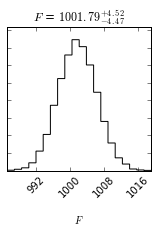

In [14]:
# http://corner.readthedocs.io/en/latest/index.html 
import corner

figure = corner.corner(accept_sample, labels=[r'$F$'], show_titles=True)

The pure Bayesian result for a problem like this would be to report the posterior distribution itself (i.e. its representative sample), and leave it at that.

## Adding a Dimension: Exploring a more sophisticated model

Varying Photon Counts, e.g. quasar

Model:

$$ F_\text{true} \sim \frac{1}{\sqrt{2 \pi \sigma^2}} \exp{\left[ \frac{-(F_i - \mu)^2}{2\sigma^2} \right]}  $$

with $\theta = [\mu, \sigma]$ as parameters model we want to derive

In [15]:
np.random.seed(16)

N = 100  # we'll use more samples for the more complicated model
mu_true, sigma_true = 1000, 15  # stochastic flux model

F_true = stats.norm(mu_true, sigma_true).rvs(N)  # (unknown) true flux
F = stats.poisson(F_true).rvs()  # observed flux: true flux plus Poisson errors.
e = np.sqrt(F)  # root-N error, as above

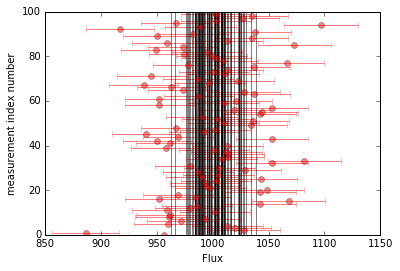

In [16]:
fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ro', ecolor='red', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=1, alpha=0.5)
ax.set_xlabel("Flux")
ax.set_ylabel("measurement index number")

### Frequentist approach

The likelihood is the convolution of the intrinsic distribution with the error distribution

$$\mathcal{L} (D | \theta) = \prod_{i=1}^{N} \frac{1}{\sqrt{2 \pi (\sigma^2 + e_i^2)}} \exp{\left[ \frac{-(F_i - \mu)^2}{2(\sigma^2 + e_i^2)} \right]}$$

Maximize the likelihood we get, 

$$ \mu_\text{est} = \frac{\sum_i^N w_i F_i}{\sum_i^N w_i}, \quad w_i = \frac{1}{\sigma^2 + e_i^2}$$

And here we have a problem: the optimal value of $\mu$ depends on the optimal value of $\sigma$

We can use <code>scipy.optimize</code> to maximize that likelihood

In [17]:
def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * (theta[1]**2 + e**2)) + (F - theta[0])**2 / (theta[1]**2 + e**2))

In [18]:
# maximize likelihood <--> minimize negative likelihood
def neg_log_likelihood(theta, F, e):
    return -log_likelihood(theta, F, e)

In [19]:
from scipy import optimize

theta_guess = [900, 5]

theta_est = optimize.fmin(neg_log_likelihood, theta_guess, args=(F, e))

print("\nMaximum likelihood estimate for {0} data points: mu={theta[0]:.0f}, sigma={theta[1]:.0f}".format(N, theta=theta_est))

Optimization terminated successfully.
         Current function value: 502.593082
         Iterations: 57
         Function evaluations: 110

Maximum likelihood estimate for 100 data points: mu=998, sigma=19


We need to determine how confident we are in this answer, that is, we need to compute the error bars on $\mu$ and $\sigma$

We can use several approaches to determining errors in a frequentist paradigm, e.g.
- fit a normal approximation to the maximum likelihood and report the covariance matrix
- compute statistics like $\mathcal{\chi}^2$ and use <a href="https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test">standard tests</a> to determine confidence limits, which also depends on strong assumptions about the Gaussianity of the likelihood
- Use resampling approach such as <a href="https://en.wikipedia.org/wiki/Jackknife_resampling">Jackknife</a> or <a href="https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29">Bootstrap</a>

In [20]:
from astroML.resample import bootstrap

In [21]:
def fit_samples(sample):
    # sample is an array of size [n_bootstraps, n_samples]
    # compute the maximum likelihood for each bootstrap.
    return np.array([optimize.fmin(neg_log_likelihood, theta_guess, args=(F, np.sqrt(F)), disp=0) for F in sample])

In [22]:
samples = bootstrap(F, 1000, fit_samples)  # 1000 bootstrap resamplings

In [23]:
mu_samp = samples[:, 0]
sig_samp = abs(samples[:, 1])

print " mu    = {0:.0f} +/- {1:.0f}".format(mu_samp.mean(), mu_samp.std())
print " sigma = {0:.0f} +/- {1:.0f}".format(sig_samp.mean(), sig_samp.std())

 mu    = 998 +/- 4
 sigma = 18 +/- 6


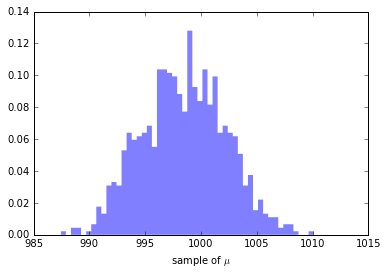

In [24]:
plt.hist(samples[:,0], normed=True, bins=50, histtype="stepfilled", alpha=0.5, linewidth=0);
plt.xlabel(r"sample of $\mu$")
plt.show()

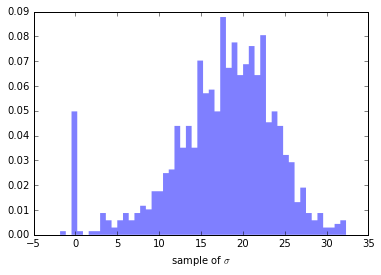

In [25]:
plt.hist(samples[:,1], normed=True, bins=50, histtype="stepfilled", alpha=0.5, linewidth=0);
plt.xlabel(r"sample of $\sigma$")
plt.show()

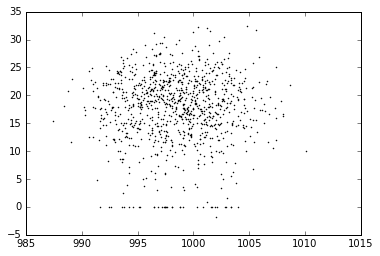

In [26]:
plt.plot(samples[:,0], samples[:,1], 'ko', ms=1)

### Bayesian approach

In [27]:
def log_prior(theta):
    # sigma must be positive
    if theta[1] <= 0:
        return -np.inf
    else:
        return 0
    
def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

# setup
ndim = 2
nwalkers = 50
nsteps = 2000
nburn = 1000

# starting guess
init_guess = np.random.rand(nwalkers, ndim)
init_guess[:,0] *= 2000 # 0 < mu < 2000
init_guess[:,1] *= 20 # 0 < sigma < 20

In [28]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(init_guess, nsteps);

In [29]:
sample = sampler.chain # shape nwalkers, nsteps, ndim
accept_sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

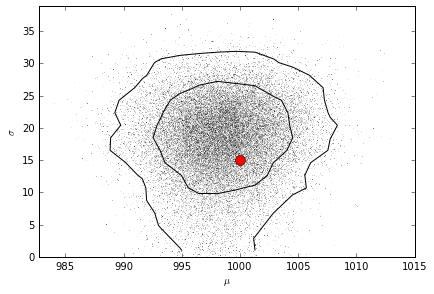

In [30]:
from astroML.plotting import plot_mcmc
fig = plt.figure()
ax = plot_mcmc(accept_sample.T, fig=fig, labels=[r'$\mu$', r'$\sigma$'], colors='k')
ax[0].plot(accept_sample[:, 0], accept_sample[:, 1], ',k', alpha=0.1)
ax[0].plot([mu_true], [sigma_true], 'o', color='red', ms=10);

The red dot indicates ground truth (from our problem setup), and the contours indicate one and two standard deviations (68% and 95% confidence levels). In other words, based on this analysis we are 68% confident that the model lies within the inner contour, and 95% confident that the model lies within the outer contour.

Note here that $\sigma=0$ is consistent with our data within two standard deviations: that is, depending on the certainty threshold you're interested in, our data are not enough to confidently rule out the possibility of a non-varying source!

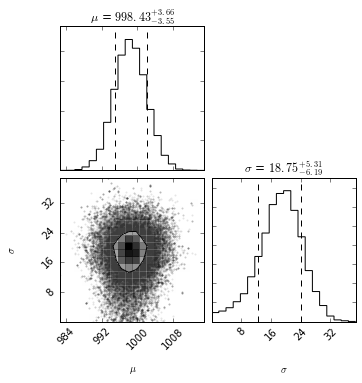

In [31]:
figure = corner.corner(accept_sample, labels=[r'$\mu$', r'$\sigma$'], quantiles=(0.16, 0.84), levels=(1-np.exp(-0.5),), show_titles=True, title_kwargs={"fontsize": 12})